# Business Data Science

Abhilash Vikram Gupta

https://www.kaggle.com/c/mis382n-fall-2019

In [244]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.calibration import CalibratedClassifierCV

import xgboost as xgb
import lightgbm as lgbm

from IPython.display import display

In [209]:
df = pd.read_csv('data/train_final.csv', index_col='Id')
df_ult = pd.read_csv('data/test_final.csv', index_col='Id')

X = df.drop('Y', axis='columns').values
y = df['Y'].values

n_features = X.shape[1]

X_ult = df_ult.values

scale_pos_weight = len(y[y == 0])/len(y[y == 1])

## Feature selection

done using forward, backward and a model's feature_importances_.

In [285]:
def get_ind(mask): return [index for index, mask_ele in enumerate(mask) if mask_ele==True]

def get_best_ind(importances, start=7, number=5):
    ranked_features = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
    return [ranked_features[:i] for i in range(start, start + number)]

def get_clf():
    return lgbm.LGBMClassifier(n_estimators=400,
                               learning_rate=0.1, 
                               boosting_type='goss', 
                               max_depth=5, 
                               num_leaves=33,
                               objective='binary', 
                               scale_pos_weight=scale_pos_weight)

In [287]:
def get_features_forward(clf):
    primary = ([], 0)

    for _ in range(n_features):
        best_feature_score = (0, 0)
        remaining_features = np.setdiff1d(list(range(n_features)), primary[0]).tolist()
        for current_feature in remaining_features:
            current_features = primary[0] + [current_feature]
            clf.fit(X[:, current_features], y)
            current_score = roc_auc_score(y, clf.predict_proba(X[:, current_features])[:, 1])
            if current_score > best_feature_score[1]:
                best_feature_score = (current_feature, current_score)
        if best_feature_score[1] > primary[1]:
            primary = (primary[0] + [best_feature_score[0]], best_feature_score[1])
        else:
            break

    print(f'score {primary[1]}.')
    return primary[0]

In [288]:
def get_features_backward(clf):
    rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
    rfecv.fit(X, y)

    return get_ind(rfecv.ranking_ == 1)

In [289]:
sorted(get_features_forward(get_clf()))

score 0.9994400774173442.


[0, 2, 3, 7, 13, 14, 15, 18, 19, 20, 21, 22]

In [290]:
get_features_backward(get_clf())

[0, 3, 7, 12, 13, 14, 15]

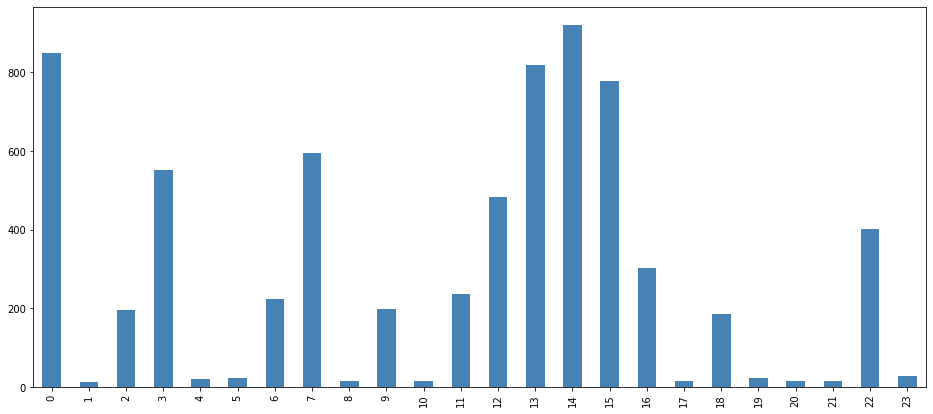

In [291]:
clf = get_clf().fit(X, y)
pd.Series(clf.feature_importances_, index=list(range(X.shape[1]))).plot.bar(color='steelblue', figsize=(16, 7));

#### Conclusions

Based on weighted average and intuition.

In [292]:
get_best_ind(clf.feature_importances_)

[[14, 0, 13, 15, 7, 3, 12],
 [14, 0, 13, 15, 7, 3, 12, 22],
 [14, 0, 13, 15, 7, 3, 12, 22, 16],
 [14, 0, 13, 15, 7, 3, 12, 22, 16, 11],
 [14, 0, 13, 15, 7, 3, 12, 22, 16, 11, 6]]

## Training

and collection of best models.

In [297]:
# params = {
# 'task':'train',
# 'numleaves': 31, 'objective': 'multiclass', 'numclass':10,
# 'mindatainleaf': 100, 'learningrate': 0.05,
# 'featurefraction': 0.85, 'baggingfraction': 0.85,
# 'baggingfreq': 2, 'metric': 'multierror',
# 'maxbin':128, 'numthreads': 32
# }

clfs = []

tuning_parameters = [{'n_estimators':                  [500], 
                      'boosting_type':                 ['goss'],
                      'learning_rate':                 [0.1], 
                      'max_depth':                     [5],
                      'num_leaves':                    [33],
                      'objective':                     ['binary'],
                      'reg_alpha':                     np.logspace(-3, -2, 2),
                      'reg_lambda':                    [1],
                      'scale_pos_weight':              [scale_pos_weight]}]

for feats in get_best_ind(clf.feature_importances_):

    X_train, X_test, y_train, y_test = train_test_split(X[:, feats], y, test_size=0.001)

    grid = GridSearchCV(lgbm.LGBMClassifier(), tuning_parameters, cv=30, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)

    print(f'Best parameters {grid.best_params_}.')
    print(f'Best accuracy is {grid.best_score_}.')
#     print(f'Best test score is {grid.score(X_test, y_test)}.')
    
    estimator = grid.best_estimator_
    clfs.append(estimator)

Best parameters {'boosting_type': 'goss', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'num_leaves': 33, 'objective': 'binary', 'reg_alpha': 0.001, 'reg_lambda': 1, 'scale_pos_weight': 0.06141885325558795}.
Best accuracy is 0.8847149354442811.
Best parameters {'boosting_type': 'goss', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'num_leaves': 33, 'objective': 'binary', 'reg_alpha': 0.001, 'reg_lambda': 1, 'scale_pos_weight': 0.06141885325558795}.
Best accuracy is 0.8802941270031897.
Best parameters {'boosting_type': 'goss', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'num_leaves': 33, 'objective': 'binary', 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 0.06141885325558795}.
Best accuracy is 0.8851039257978818.
Best parameters {'boosting_type': 'goss', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'num_leaves': 33, 'objective': 'binary', 'reg_alpha': 0.001, 'reg_lambda': 1, 'scale_pos_weight': 0.06141885325558795}.
Best a

## Generation

of submissions.

In [298]:
req_rows = 16384
preds_dfs = [pd.DataFrame(clf.predict_proba(X_ult[:, feats])[:, 1], 
                          index=list(range(req_rows, req_rows*2 + 1)), 
                          columns=['Y']) 
             for feats, clf in 
             zip(get_best_ind(clf.feature_importances_), clfs)]

for idx, df in enumerate(preds_dfs):
    df.index.name = 'Id'
    df.to_csv(f'submission_24_{idx}.csv')